In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.backend import clear_session
from tensorflow.compat.v1.keras.backend import get_session
import gc


# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))


# Config

In [3]:
class CONFIG:
    DATASET_DIR = 'birdclef-2022'
    TRAIN_DIR = os.path.join(DATASET_DIR, 'train_images')
    TEST_DIR = os.path.join(DATASET_DIR, 'test_soundscapes')

    COLOR_MODE = 'rgb' # 'grayscale or rgb
    IMG_WIDTH = 224
    IMG_HEIGHT = 224
    IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT, 3) if COLOR_MODE == 'rgb' else (IMG_WIDTH, IMG_HEIGHT)

    TEST_SIZE = 0.2
    BATCH_SIZE = 32
    EPOCHS = 20
    LEARNING_RATE = 0.0001

    MODEL_PATH = r'efficient_net'


In [4]:
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

# Disable GPU
# tf.config.set_visible_devices([], 'GPU')

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

Num GPUs Available 1
GPU found


# Data pre-processing

In [5]:
data_df = pd.read_csv(os.path.join(CONFIG.DATASET_DIR, 'train_metadata.csv'))
data_df

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,zebdov,[],"['adult', 'song']",22.6499,120.2872,Geopelia striata,Zebra Dove,Jerome Chie-Jen Ko,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:36,https://www.xeno-canto.org/629769,zebdov/XC629769.ogg
14848,zebdov,[],"['adult', 'sex uncertain', 'song']",1.4168,103.7287,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,08:00,https://www.xeno-canto.org/642415,zebdov/XC642415.ogg
14849,zebdov,[],"['adult', 'call', 'sex uncertain']",1.4347,103.7043,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/665873,zebdov/XC665873.ogg
14850,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,11:15,https://www.xeno-canto.org/666194,zebdov/XC666194.ogg


In [6]:
spec_paths = []
spec_labels = []

for thresh_folder in os.listdir(CONFIG.TRAIN_DIR):
    thresh_path = os.path.join(CONFIG.TRAIN_DIR, thresh_folder)
    for label in os.listdir(thresh_path):
        label_path = os.path.join(thresh_path, label)

        if '.json' in label:
            continue

        for filename in os.listdir(label_path):
            spec_paths.append(os.path.join(label_path, filename))
            spec_labels.append(label)

train_df = pd.DataFrame({
    'spec_path': spec_paths,
    'label': spec_labels
})


In [7]:
train_df

,spec_path,label
0,birdclef-2022\train_images\train_images_thresh...,afrsil1
1,birdclef-2022\train_images\train_images_thresh...,afrsil1
2,birdclef-2022\train_images\train_images_thresh...,afrsil1
3,birdclef-2022\train_images\train_images_thresh...,afrsil1
4,birdclef-2022\train_images\train_images_thresh...,afrsil1
...,...,...
88556,birdclef-2022\train_images\train_images_thresh...,zebdov
88557,birdclef-2022\train_images\train_images_thresh...,zebdov
88558,birdclef-2022\train_images\train_images_thresh...,zebdov
88559,birdclef-2022\train_images\train_images_thresh...,zebdov


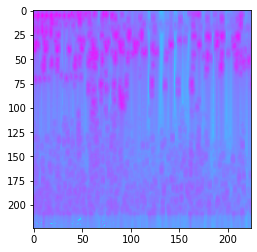

In [22]:
import random
import matplotlib.pyplot as plt

img = cv2.imread(train_df['spec_path'][random.choice(range(len(train_df)))], cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (CONFIG.IMG_SIZE[0], CONFIG.IMG_SIZE[1]), interpolation=cv2.INTER_CUBIC)
# load image using cv2....and do processing.
plt.imshow(img, cmap='gray' if CONFIG.COLOR_MODE=='grayscale' else 'cool')
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()

In [23]:
classes = train_df['label'].unique()
print(classes)

class_indices = dict()
for i, label in enumerate(classes):
    class_indices[label] = i

print(class_indices)

['afrsil1' 'akekee' 'akepa1' 'akiapo' 'akikik' 'amewig' 'aniani' 'apapan'
 'arcter' 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra'
 'blknod' 'bongul' 'brant' 'brnboo' 'brnnod' 'brnowl' 'brtcur' 'bubsan'
 'buffle' 'bulpet' 'burpar' 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas'
 'caster1' 'categr' 'chbsan' 'chemun' 'chukar' 'cintea' 'comgal1' 'commyn'
 'compea' 'comsan' 'comwax' 'coopet' 'crehon' 'dunlin' 'elepai' 'ercfra'
 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe' 'grbher3'
 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcoo' 'hawcre' 'hawgoo'
 'hawhaw' 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1'
 'jabwar' 'japqua' 'kalphe' 'kauama' 'laugul' 'layalb' 'lcspet' 'leasan'
 'leater1' 'lessca' 'lesyel' 'lobdow' 'lotjae' 'madpet' 'magpet1'
 'mallar3' 'masboo' 'mauala' 'maupar' 'merlin' 'mitpar' 'moudov' 'norcar'
 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama' 'omao' 'osprey'
 'pagplo' 'palila' 'parjae' 'pecsan' 'peflov' 'perfal

In [25]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=CONFIG.TEST_SIZE) # set validation split

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory='.',
    x_col='spec_path',
    y_col='label',
    target_size=(CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH),
    color_mode=CONFIG.COLOR_MODE,
    batch_size=CONFIG.BATCH_SIZE,
    classes=class_indices,
    class_mode='categorical',
    shuffle=True,
    seed=63,
    subset='training',
    validate_filenames=True,
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    directory='.',
    x_col='spec_path',
    y_col='label',
    target_size=(CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH),
    color_mode=CONFIG.COLOR_MODE,
    batch_size=CONFIG.BATCH_SIZE,
    classes=class_indices,
    class_mode='categorical',
    shuffle=True,
    seed=63,
    subset='validation',
    validate_filenames=True,
)

Found 70849 validated image filenames belonging to 152 classes.
Found 17712 validated image filenames belonging to 152 classes.


# Model

In [46]:
base_model = tf.keras.applications.ResNet152(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = CONFIG.IMG_SIZE)
base_model.trainable = False
# for layer in base_model.layers:
#   layer.trainable = False

# Create model
model = tf.keras.models.Sequential()

model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(units=512, activation='relu'))  
model.add(tf.keras.layers.Dense(units=len(classes), activation='softmax'))  

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG.LEARNING_RATE), 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 152)               311448    
Total params: 58,682,392
Trainable params: 311,448
Non-trainable params: 58,370,944
_________________________________________________________________
None


# Inference

## Callbacks

In [47]:
mck_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CONFIG.MODEL_PATH, f'best.h5'),
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
)

## Training

In [ ]:
# Run training on GPU
training_history = None

with tf.device('/gpu:0'):
# with tf.device('/cpu:0'):
    training_history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples // 32,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // 32,
        epochs = CONFIG.EPOCHS,
        callbacks=[mck_callback]
    )

    model.save(os.path.join(CONFIG.MODEL_PATH, 'final.h5'))
    np.save(os.path.join(CONFIG.MODEL_PATH, 'history.npy'), training_history, allow_pickle=True)

## History

In [30]:
from matplotlib import pyplot

def summarize_diagnostics(history, save_name='temp'):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.tight_layout()
    # save plot to file
    pyplot.savefig(save_name + '_plot.png')
    pyplot.show()
    pyplot.close()

In [ ]:
summarize_diagnostics(training_history, 'training_history')

# Evaluation

In [ ]:
import matplotlib.pyplot as plt
import itertools
import sys
%matplotlib inline



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')